In [ ]:
import numpy as np
import pandas as pd
from time import time
from sympy import *
import autograd.numpy as autonp
from autograd import grad, jacobian
import matplotlib.pyplot as plt
import math

LA = np.linalg

C=299792.458

# Problem Overview

- Total 24 satellites slanted 55 degree divided in 6 planes.
- Time difference = Transmitted time - Recieved time // t.
- Distance between Object and satellite = c (speed of light) * Transmission time // d.
- The final answer will contain 2 points of intersections of the signals emitting from the satellites.

- **Problem** - Atomic clocks in the satellite have nano seconds precision but clocks on Earth aren't accurate. Which can lead to large difference in the distance calculation.
Solution

- **Solution** - Add an extra satellite in the equation.

-  x, y, and z are the coordinates of the reciever.

-  A, B, and C  are the coordinates of the satellites.

*We are asked to calculate the position of the reciever (x,y,z) using numerical methods.

# Activities

## Activity 1

- 1: Given the satellites co-ordinates find receiver's co-ordinates and time correction d using Multivariate Newton Raphson method.

- 2: Construct a jacobian matrix for x, y, z, d - these are their partial derivatives.

- 3: construct a vector for the initial guess.
- 4: Apply the multivariante newton method and iterate.
- 5: Find the error.
- 6: Count the number of iterations needed to reach the smallest converence.
- 7: Plot the location results - if possible.

In [ ]:
# Initializing the Satellites

Sat1 = {"A": 15600, "B": 7540, "C": 20140, "t": 0.07074}
Sat2 = {"A": 18760, "B":2750, "C": 18610, "t": 0.07220}
Sat3 = {"A": 17610, "B": 14630, "C": 13480, "t": 0.07690}
Sat4 = {"A": 19170, "B": 610, "C": 18390, "t": 0.07242}

In [ ]:
def Recur_Newton(initial_v, inv = False):

  for i in range(10000):
      x=initial_v[0]
      y=initial_v[1]
      z=initial_v[2]
      d=initial_v[3]

      # Calculating satellites distance from the receiver's location.
      R1=(x-Sat1["A"])**2+(y-Sat1["B"])**2+(z-Sat1["C"])**2-(C*(Sat1['t']-d))**2
      R2=(x-Sat2["A"])**2+(y-Sat2["B"])**2+(z-Sat2["C"])**2-(C*(Sat2['t']-d))**2
      R3=(x-Sat3["A"])**2+(y-Sat3["B"])**2+(z-Sat3["C"])**2-(C*(Sat3['t']-d))**2
      R4=(x-Sat4["A"])**2+(y-Sat4["B"])**2+(z-Sat4["C"])**2-(C*(Sat4['t']-d))**2

      Rs = np.array([[R1], [R2], [R3], [R4]])

      # Calculating Jacobi Matrix
      J=np.array([[(2*x-2*Sat1["A"]), (2*y-2*Sat1["B"]), (2*z-2*Sat1['C']), (-2*C**2*d+2*C**2*Sat1['t'])],
                  [(2*x-2*Sat2["A"]), (2*y-2*Sat2["B"]), (2*z-2*Sat2['C']), (-2*C**2*d+2*C**2*Sat2['t'])],
                  [(2*x-2*Sat3["A"]), (2*y-2*Sat3["B"]), (2*z-2*Sat3['C']), (-2*C**2*d+2*C**2*Sat3['t'])],
                  [(2*x-2*Sat4["A"]), (2*y-2*Sat4["B"]), (2*z-2*Sat4['C']), (-2*C**2*d+2*C**2*Sat4['t'])]])
      
      A = J.T * J
      b = -J.T * Rs 
      v = A/b
      v = np.dot(LA.pinv(J), -Rs)
      initial_v += v.sum(axis=1)
  return initial_v

def Multivariate_Newton():

  # Far Earth Initials
  Far_earth = np.array([1000,1000, 50000,0], dtype=float)
  far = Recur_Newton(Far_earth)  # Calculating far earth solutions.


  # Near Earth Initials
  Near_earth = np.array([0,0,6370,0], dtype=float)
  near = Recur_Newton(Near_earth) # Calculating Near earth solutions.

  
  return far, near

In [ ]:
start = time()
far, near= Multivariate_Newton()
Newtontime = time()- start
newton_df = pd.DataFrame({"Near Earth": near, "Far Earth": far}, index=["X", "Y", "Z", "Distance"])
newton_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


,Near Earth,Far Earth
X,-41.772710,-39.747837
Y,-16.789194,-134.274144
Z,6370.059559,-9413.624554
Distance,-0.003202,0.185173


# Activity 2

Transforming the equation in this form.
$$ x\vec u_x + y\vec u_y + z\vec y_z + d\vec u_d + \vec w = 0 $$

$$ 0 = det[\vec u_y|\vec u_z|x\vec u_x + y\vec u_y + z\vec u_z + d\vec u_d + \vec w] $$

$$ 0 = det[\vec u_y|\vec u_z|x\vec u_x] + det[\vec u_y|\vec u_z|y\vec u_y] + det[\vec u_y|\vec u_z|z\vec u_z] + det[\vec u_y|\vec u_z|d\vec u_d] + det[\vec u_y|\vec u_z|\vec w] $$

In [ ]:
def Quadratic():
  
  w_1 = -C**2*(Sat1["t"]**2 - Sat4["t"]**2)  + Sat1['A']**2 - Sat4["A"]**2 + Sat1['B']**2 - Sat4['B']**2 + Sat1['C']**2 - Sat4["C"]**2
  w_2 = -C**2*(Sat1["t"]**2 - Sat3["t"]**2)  + Sat1['A']**2 - Sat3['A']**2 + Sat1['B']**2 - Sat3['B']**2 + Sat1['C']**2 - Sat3['C']**2
  w_3 = -C**2*(Sat1["t"]**2 - Sat2["t"]**2)  + Sat1['A']**2 - Sat2['A']**2 + Sat1['B']**2 - Sat2['B']**2 + Sat1['C']**2 - Sat2['C']**2

  u_x_1 = 2*(Sat4['A'] - Sat1['A'])
  u_x_2 = 2*(Sat3['A'] - Sat1['A'])
  u_x_3 = 2*(Sat2['A'] - Sat1['A'])

  u_y_1 = 2*(Sat4["B"] - Sat1['B'])
  u_y_2 = 2*(Sat3['B'] - Sat1['B'])
  u_y_3 = 2*(Sat2['B'] - Sat1['B'])

  u_z_1 = 2*(Sat4["C"] - Sat1['C'])
  u_z_2 = 2*(Sat3['C'] - Sat1['C'])
  u_z_3 = 2*(Sat2['C'] - Sat1['C'])

  u_d_1 = -2*C**2*(Sat4['t'] - Sat1["t"])
  u_d_2 = -2*C**2*(Sat3['t'] - Sat1["t"])
  u_d_3 = -2*C**2*(Sat2['t'] - Sat1["t"])
  
  # Solving the below matrices for A, B, and C w.r.t x, y, z by calculating determinants of the matrices.

  Mx1 = [[u_y_1, u_z_1, u_x_1],[u_y_2, u_z_2, u_x_2], [u_y_3, u_z_3, u_x_3]]
  ax = LA.det(Mx1)  

  Mx2 = [[u_y_1, u_z_1, u_d_1], [u_y_2, u_z_2, u_d_2], [u_y_3, u_z_3, u_d_3]]
  bx = LA.det(Mx2)

  Mx3 = [[u_y_1, u_z_1, w_1], [u_y_2, u_z_2, w_2], [u_y_3, u_z_3, w_3]]
  cx = LA.det(Mx3)

  My1 = [[u_x_1, u_z_1, u_y_1], [u_x_2, u_z_2, u_y_2], [u_x_3, u_z_3, u_y_3]]
  ay = LA.det(My1)

  My2 = [[u_x_1, u_z_1, u_d_1], [u_x_2, u_z_2, u_d_2], [u_x_3, u_z_3, u_d_3]]
  by = LA.det(My2);

  My3 = [[u_x_1, u_z_1, w_1], [u_x_2, u_z_2, w_2], [u_x_3, u_z_3, w_3]]
  cy = LA.det(My3)

  Mz1 = [[u_x_1, u_y_1, u_z_1], [u_x_2, u_y_2, u_z_2], [u_x_3, u_y_3, u_z_3]]
  az = LA.det(Mz1)

  Mz2 = [[u_x_1, u_y_1, u_d_1], [u_x_2, u_y_2, u_d_2], [u_x_3, u_y_3, u_d_3]]
  bz = LA.det(Mz2)

  Mz3 = [[u_x_1, u_y_1, w_1], [u_x_2, u_y_2, w_2], [u_x_3, u_y_3, w_3]]
  cz = LA.det(Mz3)

  q_a = (bx/ax)**2 + (by/ay)**2 + (bz/az)**2 - C**2
  q_b = 2*(bx/ax)*(cx/ax + Sat1['A']) + 2*(by/ay)*(cy/ay + Sat1['B']) + 2*(bz/az)*(cz/az + Sat1['C']) + 2*(C**2)*Sat1['t']
  q_c = (cx/ax + Sat1['A'])**2 + (cy/ay + Sat1['B'])**2 + (cz/az + Sat1['C'])**2 - (C**2)*Sat1['t']**2


  if q_b > 0:
    d_pos = - ( ( q_b + np.sqrt( (q_b**2) - (4 * q_a * q_c) ) ) / (2*q_a) )
    d_neg = - ( ( 2 * q_c ) / ( q_b + np.sqrt( q_b**2 - 4 * q_a * q_c ) ) )
  else:
    d_pos = ( -q_b + np.sqrt( q_b**2 - 4 * q_a * q_c ) ) / ( 2 * q_a )
    d_neg = ( 2 * q_c ) / ( -q_b + np.sqrt( q_b**2 - 4 * q_a * q_c) )

  x_sol_pos, x_sol_neg = -(cx / ax + (bx / ax) * d_pos), -(cx / ax + (bx / ax) * d_neg)
  y_sol_pos, y_sol_neg = -(cy / ay + (by / ay) * d_pos), -(cy / ay + (by / ay) * d_neg) 
  z_sol_pos, z_sol_neg = -(cz / az + (bz / az) * d_pos), -(cz / az + (bz / az) * d_neg)

  dis_pos = np.sqrt(x_sol_pos**2 + y_sol_pos**2 + z_sol_pos**2) - 6370
  dis_neg = np.sqrt(x_sol_neg**2 + y_sol_neg**2 + z_sol_neg**2) - 6370

  return {"X": (x_sol_neg, x_sol_pos), "Y": (y_sol_neg, y_sol_pos), "Z": (z_sol_neg, z_sol_pos), "Distance": (d_neg, d_pos)} 

In [ ]:
start =  time()
Quadratic()
quadratic_time = time() - start
quad_df = pd.DataFrame(Quadratic(), index=['Near Earth', "Far Earth"]).T
print(f"Quadratic function takes {quadratic_time} micro seconds")

Quadratic function takes 0.0005574226379394531 micro seconds


## Comparison of the methods.

In [ ]:
print(f"Newton {Newtontime} - Quadratic {quadratic_time} = ", Newtontime-quadratic_time)

Newton 2.142479658126831 - Quadratic 0.0005574226379394531 =  2.1419222354888916


In [ ]:
print("Newton - Quadratic")
newton_df - quad_df

Newton - Quadratic


,Near Earth,Far Earth
X,-4.524736e-11,-1.386269e-11
Y,-1.817568e-11,4.092726e-12
Z,5.456968e-12,-1.091394e-10
Distance,-1.019150e-16,3.053113e-16


### As Quadratic is faster and accurate we'll be using it for the rest of the activities.

# Activity 4: 

In [ ]:
# Initializing the Satellites
class Satellite:
  def __init__(self, d, phi=None, theta=None):
    P = 26570
    dti=10**-8
    self.phi=phi*np.pi/8
    self.theta=(phi-1)*np.pi/2
    self.A=(P*np.cos(self.phi)*np.cos(self.theta))
    self.B=(P*np.cos(self.phi)*np.sin(self.theta))
    self.C=P*np.sin(self.phi)
    self.R=np.sqrt(self.A**2+self.B**2+(self.C-6370)**2)
    self.time=d+(self.R/C)
  
  def get_cords(self):
    return self.A, self.B, self.C

Sat1 = Satellite(0.0001, 1 )
Sat2 = Satellite(0.0001, 2)
Sat3 = Satellite(0.0001, 3)
Sat4 = Satellite(0.0001, 4)

In [ ]:
def Quad(t1, t2, t3, t4):
  w_1 = -C**2*(t1**2 - t4**2)  + Sat1.A**2 - Sat4.A**2 + Sat1.B**2 - Sat4.B**2 + Sat1.C**2 - Sat4.C**2
  w_2 = -C**2*(t1**2 - t3**2)  + Sat1.A**2 - Sat3.A**2 + Sat1.B**2 - Sat3.B**2 + Sat1.C**2 - Sat3.C**2
  w_3 = -C**2*(t1**2 - t2**2)  + Sat1.A**2 - Sat2.A**2 + Sat1.B**2 - Sat2.B**2 + Sat1.C**2 - Sat2.C**2

  u_x_1 = 2*(Sat4.A - Sat1.A)
  u_x_2 = 2*(Sat3.A - Sat1.A)
  u_x_3 = 2*(Sat2.A - Sat1.A)

  u_y_1 = 2*(Sat4.B - Sat1.B)
  u_y_2 = 2*(Sat3.B - Sat1.B)
  u_y_3 = 2*(Sat2.B - Sat1.B)

  u_z_1 = 2*(Sat4.C - Sat1.C)
  u_z_2 = 2*(Sat3.C - Sat1.C)
  u_z_3 = 2*(Sat2.C - Sat1.C)

  u_d_1 = -2*C**2*(t4 - t1)
  u_d_2 = -2*C**2*(t3 - t1)
  u_d_3 = -2*C**2*(t2 - t1)
  
  # Solving the below matrices for A, B, and C w.r.t x, y, z by calculating determinants of the matrices.

  Mx1 = [[u_y_1, u_z_1, u_x_1],[u_y_2, u_z_2, u_x_2], [u_y_3, u_z_3, u_x_3]]
  ax = LA.det(Mx1)  

  Mx2 = [[u_y_1, u_z_1, u_d_1], [u_y_2, u_z_2, u_d_2], [u_y_3, u_z_3, u_d_3]]
  bx = LA.det(Mx2)

  Mx3 = [[u_y_1, u_z_1, w_1], [u_y_2, u_z_2, w_2], [u_y_3, u_z_3, w_3]]
  cx = LA.det(Mx3)

  My1 = [[u_x_1, u_z_1, u_y_1], [u_x_2, u_z_2, u_y_2], [u_x_3, u_z_3, u_y_3]]
  ay = LA.det(My1)

  My2 = [[u_x_1, u_z_1, u_d_1], [u_x_2, u_z_2, u_d_2], [u_x_3, u_z_3, u_d_3]]
  by = LA.det(My2);

  My3 = [[u_x_1, u_z_1, w_1], [u_x_2, u_z_2, w_2], [u_x_3, u_z_3, w_3]]
  cy = LA.det(My3)

  Mz1 = [[u_x_1, u_y_1, u_z_1], [u_x_2, u_y_2, u_z_2], [u_x_3, u_y_3, u_z_3]]
  az = LA.det(Mz1)

  Mz2 = [[u_x_1, u_y_1, u_d_1], [u_x_2, u_y_2, u_d_2], [u_x_3, u_y_3, u_d_3]]
  bz = LA.det(Mz2)

  Mz3 = [[u_x_1, u_y_1, w_1], [u_x_2, u_y_2, w_2], [u_x_3, u_y_3, w_3]]
  cz = LA.det(Mz3)

  q_a = (bx/ax)**2 + (by/ay)**2 + (bz/az)**2 - C**2
  q_b = 2*(bx/ax)*(cx/ax + Sat1.A) + 2*(by/ay)*(cy/ay + Sat1.B) + 2*(bz/az)*(cz/az + Sat1.C) + 2*(C**2)*t1
  q_c = (cx/ax + Sat1.A)**2 + (cy/ay + Sat1.B)**2 + (cz/az + Sat1.C)**2 - (C**2)*t1**2


  if q_b > 0:
    d_pos = - ( ( q_b + np.sqrt( (q_b**2) - (4 * q_a * q_c) ) ) / (2*q_a) )
    d_neg = - ( ( 2 * q_c ) / ( q_b + np.sqrt( q_b**2 - 4 * q_a * q_c ) ) )
  else:
    d_pos = ( -q_b + np.sqrt( q_b**2 - 4 * q_a * q_c ) ) / ( 2 * q_a )
    d_neg = ( 2 * q_c ) / ( -q_b + np.sqrt( q_b**2 - 4 * q_a * q_c) )

  x_sol_pos, x_sol_neg = -(cx / ax + (bx / ax) * d_pos), -(cx / ax + (bx / ax) * d_neg)
  y_sol_pos, y_sol_neg = -(cy / ay + (by / ay) * d_pos), -(cy / ay + (by / ay) * d_neg) 
  z_sol_pos, z_sol_neg = -(cz / az + (bz / az) * d_pos), -(cz / az + (bz / az) * d_neg)

  dis_pos = np.sqrt(x_sol_pos**2 + y_sol_pos**2 + z_sol_pos**2) - 6370
  dis_neg = np.sqrt(x_sol_neg**2 + y_sol_neg**2 + z_sol_neg**2) - 6370
  return x_sol_neg, y_sol_neg , z_sol_neg, dis_neg



In [ ]:
def EMF(delta_t):
  actual_x = 0.0
  actual_y = 0.0
  actual_z = 6370
  actual_d = 0.0001

  P = 26570

  maxerr_disp = [] # input error vector in the maximum error case
  maxerr_vect = []  # calculated observer position in the maximum error case
  maxerr = 0       # maximum position error (in individual coordinate)

  for i in range(-1, 2):
    for j in range(-1, 2):
      for k in range(-1, 2):
        for l in range(-1, 2):

          # Initialize vector is close to actual value but off by 10km initially
          init_vec = [10, 10, 6380, 0]

          # Calculate time delays recorded by observer
          t1 = Sat1.time + i * delta_t
          t2 = Sat2.time + j * delta_t
          t3 = Sat3.time + k * delta_t
          t4 = Sat4.time + l * delta_t

          init_vec[0], init_vec[1], init_vec[2], init_vec[3] = Quad(t1, t2, t3, t4)
          err = np.max(np.abs([init_vec[0]-actual_x, init_vec[1]-actual_y, init_vec[2]-actual_z]))
          if err > maxerr:
                  maxerr_disp = np.array([i, j, k, l]) * delta_t;
                  maxerr_vect = init_vec
                  maxerr = err
         
  return maxerr, maxerr / (C * delta_t)

maxerr, emf = EMF(10**-8)
print(f"Maximum error is {maxerr}, and EMF is {emf}")

Maximum error is 0.016414542518759845, and EMF is 5.475302023361724


## Plotting the three satellites

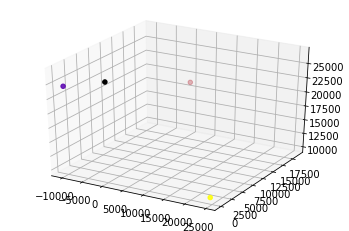

In [ ]:
fig = plt.figure()
 
# Defining the axes with the projection as 3D so as to plot 3D graphs
ax = plt.axes(projection="3d")
 
# creating a wide range of points x,y,z
x= [Sat1.A, Sat2.A, Sat3.A, Sat4.A]
y= [Sat1.B, Sat2.B, Sat3.B, Sat4.B]
z= [Sat1.C, Sat2.C, Sat3.C, Sat4.C]
 
# Plotting a scatter plot with X-coordinate, Y-coordinate and Z-coordinate respectively and defining the points color as cividis and defining c as z which basically is a 
# definition of 2D array in which rows are RGB or RGBA
ax.scatter3D(x, y, z, c=z, cmap='gnuplot_r');
plt.show()

# Activity 5

## Case 1: When the satellites are somewhat clustered.

In [ ]:
# Initializing the Satellites
class Satellite:
  def __init__(self, d, idx, phi=None, theta=None):
    P = 26570
    dti=10**-8
    if phi:
      self.phi = phi
    else:
      self.phi=(np.pi/2)+(idx-1)*(5/100)*np.pi/2
    if theta:
      self.theta = theta
    else:
      self.theta= (idx-1)*(5/100)*2*np.pi
    self.A=(P*np.cos(self.phi)*np.cos(self.theta))
    self.B=(P*np.cos(self.phi)*np.sin(self.theta))
    self.C=P*np.sin(self.phi)
    self.R=np.sqrt(self.A**2+self.B**2+(self.C-6370)**2)
    self.time=d+(self.R/C)
  
  def get_cords(self):
    return self.A, self.B, self.C

### Delta t = 0

In [ ]:
Sat1 = Satellite(0.0001, 1, 0.5, 1.5)
Sat2 = Satellite(0.0001, 2, 0.75, 2)
Sat3 = Satellite(0.0001, 3, 1, 2.5)
Sat4 = Satellite(0.0001, 4, 1.25, 3)
max_error, emf  = EMF(0)
print(f"Max error {max_error}, and EMF is {emf}")

Max error 1.000444171950221e-11, and EMF is inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


### Delta t = 10^-8

In [ ]:
Sat1 = Satellite(0.0001, 1, 0.5, 1.5)
Sat2 = Satellite(0.0001, 2, 0.75, 2)
Sat3 = Satellite(0.0001, 3, 1, 2.5)
Sat4 = Satellite(0.0001, 4, 1.25, 3)
max_error, emf  = EMF(10**-8)
print(f"Max error {max_error}, and EMF is {emf}")

Max error 0.2149067650352663, and EMF is 71.68518063095047


## Case 2: When the satellites are tightly clustered

### Delta t = 0

In [ ]:
Sat1 = Satellite(0.0001, 1)
Sat2 = Satellite(0.0001, 2)
Sat3 = Satellite(0.0001, 3)
Sat4 = Satellite(0.0001, 4)
max_error, emf  = EMF(0)
print(f"Max error {max_error}, and EMF is {emf}")

Max error 4.089997673872858e-09, and EMF is inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


### Delta t = 10^-8

In [ ]:
Sat1 = Satellite(0.0001, 1)
Sat2 = Satellite(0.0001, 2)
Sat3 = Satellite(0.0001, 3)
Sat4 = Satellite(0.0001, 4)
max_error, emf  = EMF(10**-8)
print(f"Max error {max_error}, and EMF is {emf}")

Max error 7.527553158578485, and EMF is 2510.921458397224


# Activity 6

In [ ]:
#initializing the problem at hand
class Satellite:
  def __init__(self, idx, d):
    P = 26570
    dti=10**-4
    self.phi=idx*np.pi/16
    self.theta=(idx-1)*np.pi/4
    self.A=(P*np.cos(self.phi)*np.cos(self.theta))
    self.B=(P*np.cos(self.phi)*np.sin(self.theta))
    self.C=P*np.sin(self.phi)
    self.R=np.sqrt(self.A**2+self.B**2+(self.C-6370)**2)
    self.time=d+(self.R/C)
  
  def get_cords(self):
    return self.A, self.B, self.C

Sat1 = Satellite(1, 0.0001)
Sat2 = Satellite(2, 0.0001)
Sat3 = Satellite(3, 0.0001)
Sat4 = Satellite(4, 0.0001)
Sat5 = Satellite(5, 0.0001)
Sat6 = Satellite(6, 0.0001)
Sat7 = Satellite(7, 0.0001)
Sat8 = Satellite(8, 0.0001)

### We tried using the Quadratic but we were getting some errors. That's why we did it using the Multivariate Newton's method.

In [ ]:
def TimeEMF(delta_t, phi, theta):
  actual_x = 0.0
  actual_y = 0.0
  actual_z = 6370
  actual_d = 0.0001

  P = 26570

  maxerr_disp = [] # input error vector in the maximum error case
  maxerr_vect = []  # calculated observer position in the maximum error case
  maxerr = 0       # maximum position error (in individual coordinate)

  # Looping on all the combinations of Time values from the question.
  for i in range(-1, 2):
    for j in range(-1, 2):
      for k in range(-1, 2):
        for l in range(-1, 2):
          for M in range(-1,2):
            for N in range(-1, 2):
              for O in range(-1, 2):
                for P in range(-1, 2):
                  # Calculate time delays recorded by observer
                  t1 = Sat1.time + i * delta_t
                  t2 = Sat2.time + j * delta_t
                  t3 = Sat3.time + k * delta_t
                  t4 = Sat4.time + l * delta_t
                  t5 = Sat5.time + M * delta_t
                  t6 = Sat6.time + N * delta_t
                  t7 = Sat7.time + O * delta_t
                  t8 = Sat8.time + P * delta_t

          # Initialize vector is close to actual value but off by 10km initially
          init_vec = [0.19634954084,0.39269908169,0.5890486225,0.7853981634,0.9817477042,1.1780972451,1.3744467859,1.5707963268]

          # Recursive Multivariate Newton's method
          for iter in range(20):
            x = init_vec[0]
            y = init_vec[1]
            z = init_vec[2]
            d = init_vec[3]
            
            f1 = np.array((x- Sat1.A)**2 + (y- Sat1.B)**2 + (z-Sat1.C)**2 - (C*np.array([t1-d]))**2)
            f2 = np.array((x-Sat2.A)**2 + (y-Sat2.B)**2 + (z-Sat2.C)**2 - (C*np.array([t2-d]))**2)
            f3 = np.array((x-Sat3.A)**2 + (y-Sat3.B)**2 + (z-Sat3.C)**2 - (C*np.array([t3-d]))**2)
            f4 = np.array((x-Sat4.A)**2 + (y-Sat4.B)**2 + (z-Sat4.C)**2 - (C*np.array([t4-d]))**2)
            f5 = np.array((x-Sat5.A)**2 + (y-Sat5.B)**2 + (z-Sat5.C)**2 - (C*np.array([t5-d]))**2)
            f6 = np.array((x-Sat6.A)**2 + (y-Sat6.B)**2 + (z-Sat6.C)**2 - (C*np.array([t6-d]))**2)
            f7 = np.array((x-Sat7.A)**2 + (y-Sat7.B)**2 + (z-Sat7.C)**2 - (C*np.array([t7-d]))**2)
            f8 = np.array((x-Sat8.A)**2 + (y-Sat8.B)**2 + (z-Sat8.C)**2 - (C*np.array([t8-d]))**2)
            
            f_sol = np.array([f1, f2, f3, f4,f5,f6,f7,f8])
            Jacobian = np.array([[x - Sat1.A, y - Sat1.B, z - Sat1.C, C**2*(t1 - d)], 
                         [x - Sat2.A, y - Sat2.B, z - Sat2.C, C**2*(t2 - d)],
                         [x - Sat3.A, y - Sat3.B, z - Sat3.C, C**2*(t3 - d)],
                         [x - Sat4.A, y - Sat4.B, z - Sat4.C, C**2*(t4 - d)],
                         [x - Sat5.A, y - Sat5.B, z - Sat5.C, C**2*(t5 - d)],
                         [x - Sat6.A, y - Sat6.B, z - Sat6.C, C**2*(t6 - d)],
                         [x - Sat7.A, y - Sat7.B, z - Sat7.C, C**2*(t7 - d)],
                         [x - Sat8.A, y - Sat8.B, z - Sat8.C, C**2*(t8 - d)]])

            
            s = Jacobian/(-f_sol)
            init_vec += np.sum(s, axis=1)
          err = np.max(np.abs([init_vec[0]-actual_x, init_vec[1]-actual_y, init_vec[2]-actual_z]))
          if err > maxerr:
                  maxerr_disp = np.array([i, j, k, l,M,N,O,P]) * delta_t;
                  maxerr_vect = init_vec
                  maxerr = err
         
  return maxerr, maxerr / (C * delta_t)

maxerror, condNumber = TimeEMF(10**-4, np.pi/4, np.pi/2)
maxerror, condNumber

(6382.163630643575, 212.8860636862177)

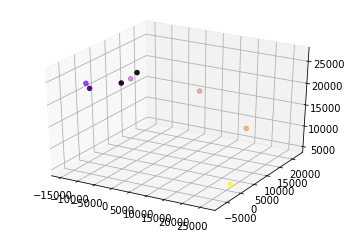

In [ ]:
fig = plt.figure()
 
# Defining the axes with the projection as 3D so as to plot 3D graphs
ax = plt.axes(projection="3d")
 
# creating a wide range of points x,y,z
x= [Sat1.A, Sat2.A, Sat3.A, Sat4.A,Sat5.A, Sat6.A, Sat7.A, Sat8.A]
y= [Sat1.B, Sat2.B, Sat3.B, Sat4.B,Sat5.B, Sat6.B, Sat7.B, Sat8.B]
z= [Sat1.C, Sat2.C, Sat3.C, Sat4.C,Sat5.C, Sat6.C, Sat7.C, Sat8.C]
 
# Plotting a scatter plot with X-coordinate, Y-coordinate and Z-coordinate respectively and defining the points color as cividis and defining c as z which basically is a 
# definition of 2D array in which rows are RGB or RGBA
ax.scatter3D(x, y, z, c=z, cmap='gnuplot_r');
plt.show()

# References
- Solve Linear Equations using Determinants method: https://byjus.com/jee/system-of-linear-equations-using-determinants/

- Multivariate Newton's method: https://drlvk.github.io/nm/section-multivariate-newton.html

- Goerge Mason: https://mason.gmu.edu/~acurran3/RealityCheck4/RC_4.html

- https://www.codespeedy.com/calculate-derivative-functions-in-python/
- https://stackoverflow.com/questions/61116868/python-numpy-linalg-linalgerror-last-2-dimensions-of-the-array-must-be-square

- https://stackoverflow.com/questions/49553006/compute-the-jacobian-matrix-in-python